## Восстановление золота из руды

<a id="up"></a>

### Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.



### Задачи исследования

### [1. Загрузите и подготовьте данные.](#1)

- Откройте файлы и изучите их.
- Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака `rougher.output.recovery`. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.
- Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
- Проведите предобработку данных.

### [2. Анализ данных](#2)

- Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.
- Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
- Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

### [3. Модель](#3)

- Напишите функцию для вычисления итоговой sMAPE.
- Обучите разные модели и оцените их качество кросс-валидацией. 
- Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

### Описание данных

Данные находятся в трёх файлах:

- `gold_recovery_train_new.csv` — обучающая выборка;
- `gold_recovery_test_new.csv` — тестовая выборка;
- `gold_recovery_full_new.csv` — исходные данные.

Данные индексируются датой и временем получения информации `(признак date)`. Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

##### Технологический процесс

- `Rougher feed` — исходное сырье
- `Rougher additions (или reagent additions)` — флотационные реагенты: Xanthate, Sulphate, Depressant
- `Xanthate **`— ксантогенат (промотер, или активатор флотации);
- `Sulphate` — сульфат (на данном производстве сульфид натрия);
- `Depressant` — депрессант (силикат натрия).
- `Rougher process (англ. «грубый процесс»)` — флотация
- `Rougher tails` — отвальные хвосты
- `Float banks` — флотационная установка
- `Cleaner process` — очистка
- `Rougher Au` — черновой концентрат золота
- `Final Au` — финальный концентрат золота

Параметры этапов

- `air amount` — объём воздуха
- `fluid levels` — уровень жидкости
- `feed size` — размер гранул сырья
- `feed rate` — скорость подачи

Наименование признаков

Наименование признаков должно быть такое:
- `[этап].[тип_параметра].[название_параметра]`
 - Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:
- `rougher` — флотация
- `primary_cleaner` — первичная очистка
- `secondary_cleaner` — вторичная очистка
- `final` — финальные характеристики

Возможные значения для блока [тип_параметра]:

- `input` — параметры сырья
- `output` — параметры продукта
- `state` — параметры, характеризующие текущее состояние этапа
- `calculation` — расчётные характеристики


<a id="1"></a>

### 1. Загрузим и подготовим данные.

In [41]:
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np

import math
import sklearn

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [42]:
try:
    data_train = pd.read_csv('gold_recovery_train_new.csv') #обучающая выборка
    data_test = pd.read_csv('gold_recovery_test_new.csv') # тестовая выборка
    data_full = pd.read_csv('gold_recovery_full_new.csv') # исходные данные
except Exception as e:
    print(e)
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [43]:
def information(data):

    display(data.head())
    print(data.info(),'\n') 
    print('Кол-во дубликатов =', data.duplicated().sum(),'\n')
    print('Пропуски: ','\n', data.isna().sum(),'\n')

In [44]:
information(data_train)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [45]:
information(data_test)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [46]:
information(data_full)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


#### проверим, что эффективность обогащения рассчитана правильно

для расчета Recovery будем использовать следующие признаки:
- C — доля золота в концентрате после флотации/очистки `rougher.output.concentrate_au`;
- F — доля золота в сырье/концентрате до флотации/очистки `rougher.input.feed_au`;
- T — доля золота в отвальных хвостах после флотации/очистки ` rougher.output.tail_au`.


In [47]:
input_recovery  = data_train[:]

C = input_recovery['rougher.output.concentrate_au']
F = input_recovery['rougher.input.feed_au']
T = input_recovery['rougher.output.tail_au']

input_recovery['rougher.output.recovery.check'] = (C * (F - T)) / (F * (C - T)) * 100
input_recovery.dropna(inplace=True)

print('Абсолютная средняя ошибка (MAE):', mean_absolute_error(input_recovery['rougher.output.recovery'],
                                                              input_recovery['rougher.output.recovery.check']))

Абсолютная средняя ошибка (MAE): 9.82970122149377e-15


##### Вывод:
Ошибка крайне мала, эффективность обогащения рассчитана правильно.

#### проанализируем признаки, недоступные в тестовой выборке

In [48]:
set(data_train.columns) - set(data_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

##### Вывод:
В тестовой выборке отсутствуют:

- выходные параметры продукта: `output` т.к. это целевые признаки 
- признаки `calculation` для этапа `rougher`, видимо эти данные рассчитываются позднее и не доступны во время процесса

Тип данных отсутствующих признаков: float64.

#### проведем предобработку данных

##### full

In [49]:
# заполним пропуски features
full_target_rougher = data_full['rougher.output.recovery']
full_target_final = data_full['final.output.recovery']
full_features = data_full.drop(['final.output.recovery','rougher.output.recovery'], axis=1)
full_features.ffill(axis=0,inplace=True)

# добавляем их обратно и сбросим пропуски у целевых
full_features['rougher.output.recovery'] = full_target_rougher
full_features['final.output.recovery'] = full_target_final
full = full_features.dropna()
full.reset_index(inplace=True, drop = True)

##### train

In [50]:
train_target_rougher = data_train['rougher.output.recovery']
train_target_final = data_train['final.output.recovery']
train_features = data_train.drop(['final.output.recovery','rougher.output.recovery'], axis=1)
train_features.ffill(axis=0,inplace=True)
train_features['rougher.output.recovery'] = train_target_rougher
train_features['final.output.recovery'] = train_target_final
train = train_features.dropna()
train.reset_index(inplace=True, drop = True)

##### test

In [51]:
test = data_test.ffill(axis=0)
# добавим целеые признаци из full
test = test.merge(right = full[['final.output.recovery','date']], how='left', on='date')
test = test.merge(right = full[['rougher.output.recovery','date']], how='left', on='date')
test = test.dropna()

In [52]:
# из обучающей выборки удалим признаки отсутствующие тестовой
column = list(test.columns)
train = train[column]

In [53]:
print(train.shape)
print(test.shape)

(14149, 55)
(5290, 55)


##### Вывод:
- заполнили пропуски в данных
- подготовили обучающую и тестовую выборки, оставили в выборках одинаковое количество признаков

<a id="2"></a>

### 2. Анализ данных.

#### посмотрим, как меняется концентрация металлов `Au, Ag, Pb` на различных этапах очистки:

- ###### на выходе

In [54]:
# Создадим выборки по металлам
conc_au = full[['rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']]
conc_ag = full[['rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']]
conc_pc = full[['rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']]

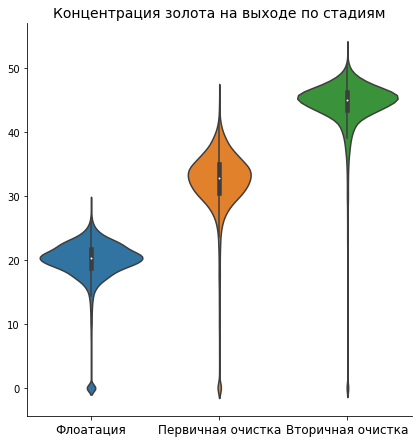

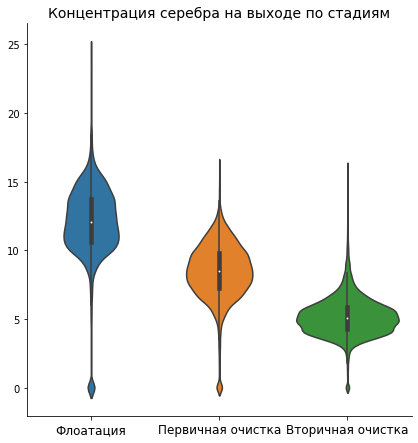

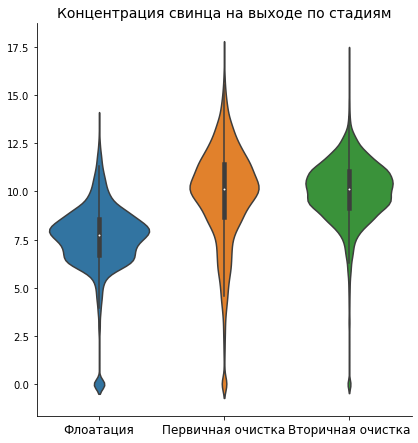

In [55]:
au = sbn.catplot(data=conc_au,  kind='violin', height = 6)
au.set_xticklabels(['Флоатация','Первичная очистка','Вторичная очистка'], fontsize=12)
plt.title('Концентрация золота на выходе по стадиям', fontsize=14) 
plt.show()

ag = sbn.catplot(data=conc_ag, kind='violin',height = 6)
ag.set_xticklabels(['Флоатация','Первичная очистка','Вторичная очистка'], fontsize=12)
plt.title('Концентрация серебра на выходе по стадиям', fontsize=14) 
plt.show()

pb = sbn.catplot(data=conc_pc, kind='violin',height = 6)
pb.set_xticklabels(['Флоатация','Первичная очистка','Вторичная очистка'], fontsize=12)
plt.title('Концентрация свинца на выходе по стадиям', fontsize=14) 
plt.show()

- ###### в хвосте

In [56]:
# Создадим выборки по металлам
conc_au_tail = full[['rougher.output.tail_au','primary_cleaner.output.tail_au','final.output.tail_au']]
conc_ag_tail = full[['rougher.output.tail_ag','primary_cleaner.output.tail_ag','final.output.tail_ag']]
conc_pc_tail = full[['rougher.output.tail_pb','primary_cleaner.output.tail_pb','final.output.tail_pb']]

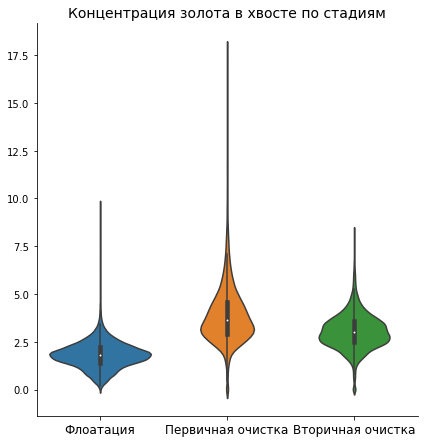

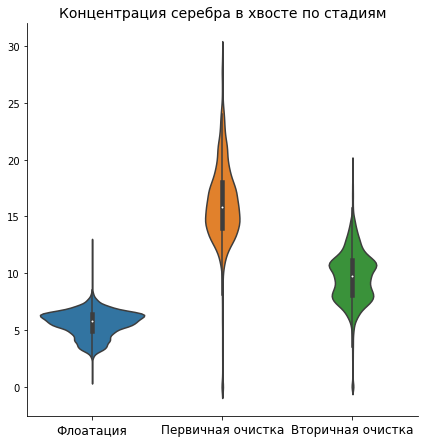

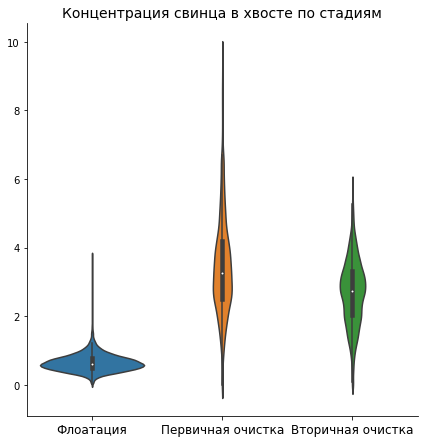

In [57]:
au = sbn.catplot(data=conc_au_tail,  kind='violin', height = 6)
au.set_xticklabels(['Флоатация','Первичная очистка','Вторичная очистка'], fontsize=12)
plt.title('Концентрация золота в хвосте по стадиям', fontsize=14) 
plt.show()

ag = sbn.catplot(data=conc_ag_tail, kind='violin',height = 6)
ag.set_xticklabels(['Флоатация','Первичная очистка','Вторичная очистка'], fontsize=12)
plt.title('Концентрация серебра в хвосте по стадиям', fontsize=14) 
plt.show()

pb = sbn.catplot(data=conc_pc_tail, kind='violin',height = 6)
pb.set_xticklabels(['Флоатация','Первичная очистка','Вторичная очистка'], fontsize=12)
plt.title('Концентрация свинца в хвосте по стадиям', fontsize=14) 
plt.show()

##### Вывод:
- с каждым этапом очистки доля золота увеличивается, а доля серебра уменьшается
- имеется различная концентрация металлов в хвостовых отвалах с каждым этапом
- большое количество нулевых значений

#### сравним распределение размеров гранул сырья на обучающей и тестовой выборках

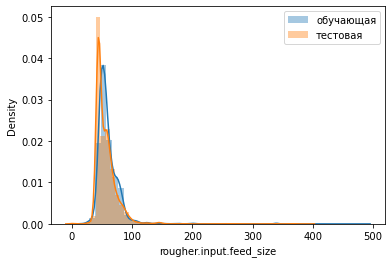

In [58]:
sbn.distplot(train['rougher.input.feed_size'].dropna(), label='обучающая')
sbn.distplot(test['rougher.input.feed_size'].dropna(), label='тестовая')
plt.legend()

##### Вывод:
Распределения размеров гранул сырья на обучающей и тестовой выборках слабо отличаются, различия не должны влиять на оценку модели.

#### исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [59]:

full['raw'] = full[['rougher.input.feed_au',
                    'rougher.input.feed_ag',
                    'rougher.input.feed_pb', 
                    'rougher.input.feed_sol']].sum(axis=1)

full['rough_concentrate'] = full[['rougher.output.concentrate_au', 
                                  'rougher.output.concentrate_ag', 
                                  'rougher.output.concentrate_pb', 
                                  'rougher.output.concentrate_sol']].sum(axis=1)

full['final_concentrate'] = full[['final.output.concentrate_au', 
                                  'final.output.concentrate_ag', 
                                  'final.output.concentrate_pb',
                                  'final.output.concentrate_sol']].sum(axis=1)

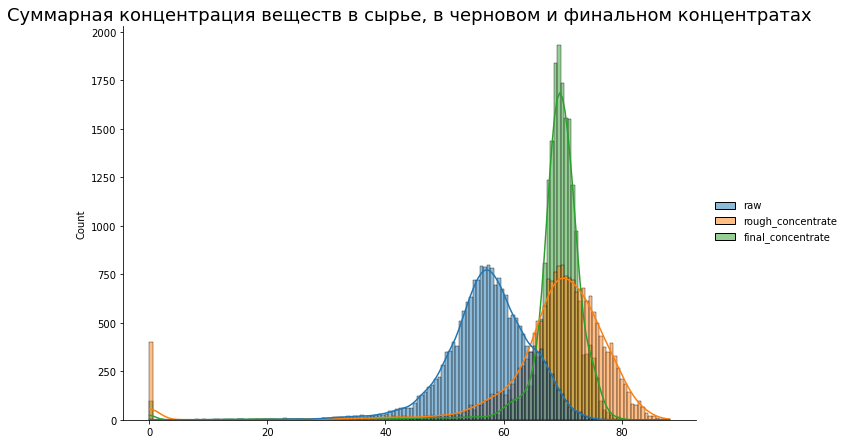

In [60]:
sbn.displot(full[['raw', 'rough_concentrate', 'final_concentrate']],
            legend=True, kde=True, height=6, aspect=1.5)  
plt.title('Суммарная концентрация веществ в сырье, в черновом и финальном концентратах', fontsize=18)
plt.show()


По распределению видно, что присутствуют выбросы. Есть много значений от 0 до 40, которые можно удалить, чтобы не мешали обучению модели.

In [61]:
full_good = full[
         (full['raw'] >  40) & 
         (full['rough_concentrate'] > 40) & 
         (full['final_concentrate'] > 40)
]

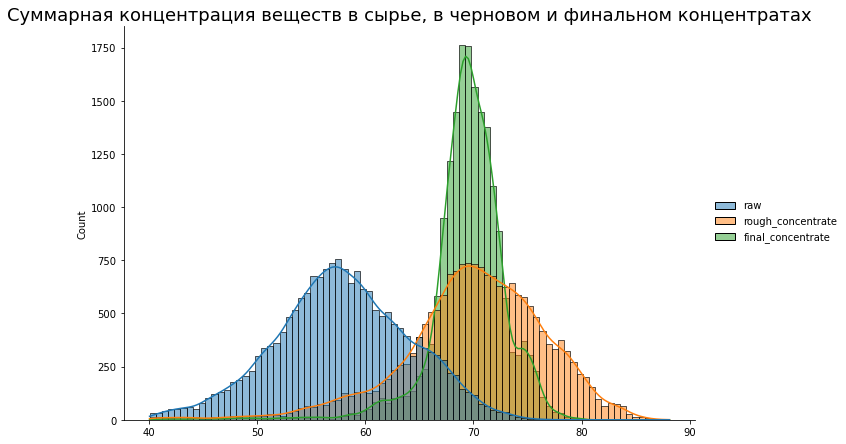

In [62]:
sbn.displot(full_good[['raw', 'rough_concentrate', 'final_concentrate']],
            legend=True, kde=True, height=6, aspect=1.5)  
plt.title('Суммарная концентрация веществ в сырье, в черновом и финальном концентратах', fontsize=18)
plt.show()

чтобы не искажать дальнейшую модель удалим найденные объекты из обучающей и тестовой выборок.

In [63]:
train_good = train[train['date'].isin(full_good['date'])]
test_good = test[test['date'].isin(full_good['date'])]

In [64]:
# удаляем пропуски
train_good.dropna(inplace=True) 
test_good.dropna(inplace=True) 

##### Вывод:
Проанализировали:
- изменения концентрации металлов на разных этапах: доля золота увеличивается, доля серебра незначительно уменьшается
- распределения размеров гранул на обучающей и тестовой выборке: они распределяются с незначительными отличиями, что не влияет на оценку модели
- суммарную концентрацию всех веществ на разных стадиях,были обнаружены аномалии, убрали найденные аномалии из обучающей и тестовой выборок.

<a id="3"></a>

### 3. Модель.

#### функция для вычисления итоговой sMAPE

In [65]:
def smape(target, predictions):
    numerator = abs(predictions - target)
    denominator = (abs(target) + abs(predictions)) / 2
    summa = (numerator / denominator).sum()
    smape = 1 / len(target) * summa * 100
    return smape

In [66]:
def smape_total (smape_rougher, smape_final):
    smape_total = 0.25 * smape_rougher + 0.75 * smape_final
    return smape_total

#### обучим разные модели и оценим их качество кросс-валидацией

In [67]:
# Разделим датафреймы на features и target

# train
target_rougher_train = train_good['rougher.output.recovery']
target_final_train = train_good['final.output.recovery']
features_train = train_good.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

# test
target_rougher_test = test_good['rougher.output.recovery']
target_final_test = test_good['final.output.recovery']
features_test = test_good.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

In [68]:
# Маштабируем признаки
numeric = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

##### линейная регрессия

In [69]:
#scorer = make_scorer(smape, greater_is_better=False) - ошибка

scorer = make_scorer(smape)
    
cross_val_score_rougher = cross_val_score(LinearRegression(),
                                          features_train,
                                          target_rougher_train,
                                          cv=4, scoring=scorer).mean()
cross_val_score_final = cross_val_score(LinearRegression(),
                                        features_train,
                                        target_final_train,
                                        cv=4, scoring=scorer).mean()
smape_total_result  = smape_total(cross_val_score_rougher, cross_val_score_final)
print('sMAPE:', smape_total_result )

sMAPE: 9.711823789292588


##### дерево решений

In [70]:
cross_val_score_rougher = cross_val_score(DecisionTreeRegressor(random_state=12345),
                                          features_train,
                                          target_rougher_train,
                                          cv=4, scoring=scorer).mean()
cross_val_score_final = cross_val_score(DecisionTreeRegressor(random_state=12345),
                                        features_train,
                                        target_final_train,
                                        cv=4, scoring=scorer).mean()
smape_total_result = smape_total(cross_val_score_rougher, cross_val_score_final)
print('sMAPE:', smape_total_result)

sMAPE: 13.280758431097073


##### случайный лес

In [71]:
for depth in range(3, 4): 
    for estimator in range(20, 21):
        
        model = RandomForestRegressor(random_state=12345, 
                                       n_estimators=estimator, 
                                       max_depth=depth)
        
        # scorer = make_scorer(smape, greater_is_better=False) - ошибка
        scorer = make_scorer(smape)
    
        cross_val_score_rougher = cross_val_score(model, features_train, target_rougher_train, cv=4, scoring=scorer).mean()
        cross_val_score_final = cross_val_score(model, features_train, target_final_train, cv=4, scoring=scorer).mean()

        smape_total_result = smape_total(cross_val_score_rougher, cross_val_score_final)
        print('sMAPE:', smape_total_result)

sMAPE: 9.131868910635916


Случайный лес показывает лучшую метрику, используем его для тестовой выборки

##### проверим модель Случайного леса на тестовой выборке

In [72]:
model_final = RandomForestRegressor(random_state=12345, 
                                       n_estimators=20, 
                                       max_depth=3)

model_final.fit(features_train, target_rougher_train)
predictions_rougher = model_final.predict(features_test)

model_final.fit(features_train, target_final_train)
predictions_final = model_final.predict(features_test)

smape_rougher = smape(target_rougher_test, predictions_rougher)
smape_final = smape(target_final_test, predictions_final)

print('sMAPE:', smape_total(smape_rougher, smape_final))

sMAPE: 6.812756504149846


##### проверим на адекватность

In [73]:
# Создадим константную модель с помошью DummyRegressor. 
#С параметром strategy='mean' всегда предсказывает среднее значение обучающей выборки.
model = DummyRegressor(strategy='mean')

model.fit(features_train, target_rougher_train)
predictions_rougher = model.predict(features_test)

model.fit(features_train, target_final_train)
predictions_final = model.predict(features_test)

smape_rougher= smape(target_rougher_test, predictions_rougher)
smape_final= smape(target_final_test, predictions_final)

print('sMAPE', smape_total(smape_rougher, smape_final))

sMAPE 7.233774341688749


##### Вывод:
- была написана функция для вычисления sMAPE
- были обучены и изучены на качество с помощью методов кросс-валидации модели `LinearRegression`, `DecisionTreeRegressor` и `RandomForestRegressor`
- выбрали лучшую модель `RandomForestRegressor` и проверили ее на адекватность

##### [к оглавлению](#up)